In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [13]:
from utils import WindowGenerator

In [14]:
dataframe = pd.read_csv("Google Finance.csv")
dataframe.head()

,Date,Close
0,02/01/2023 16:56:00,"14,3"
1,03/01/2023 16:56:00,"14,57"
2,04/01/2023 16:56:00,"14,97"
3,05/01/2023 16:56:00,"14,8"
4,06/01/2023 16:56:00,"14,55"


# Tratamento de Dados

## String para Decimal

Os valores numéricos estão representados como strings. É preciso convertê-los.

In [15]:
dataframe['Close'] = dataframe['Close'].str.replace(',', '.')
dataframe['Close'] = pd.to_numeric(dataframe['Close'])

## Visualizar dados

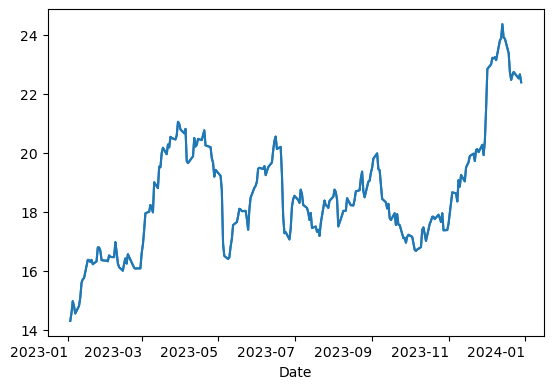

In [16]:
date_time = pd.to_datetime(dataframe.pop('Date'), format='%d/%m/%Y %H:%M:%S')

plot_features = dataframe['Close']
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = dataframe['Close'][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

## Filtros

Os filtros a seguir não se aplicam ao projeto atual devido ao dataset utilizado, porém podem ser interessantes posteriormente.

In [17]:
# Filtrar colunas com mais de 90% de elementos nulos

# dataframe = dataframe[dataframe.columns[dataframe.isnull().mean() < 0.90]]

In [18]:
# Tratando NaN's

# dataframe = dataframe.interpolate()
# dataframe = dataframe.fillna(method='bfill')

# Tratamento para a Rede Neural

## Criando entradas e saídas de treino

As entradas (X_train) são os 60 valores anteriores do preço da ação. A saída é o valor seguinte.

A seguir, também serão divididos os datasets de treino e de avaliação. Aprox. 70% dos dados serão
usados no treino, e o restante na avaliação.

É importante notar também que a divisão foi feita seguindo a ordem dos dados no arquivo (os 70%
primeiros são para treino, os 30% últimos para avaliação). Pode ser interessante mudar isso.

In [19]:
dataset = dataframe.iloc[:, 0].values

# Separação entre treino e avaliação

training_df = dataframe.iloc[0:int(dataset.shape[0] * 0.7), :]
test_df = dataframe.iloc[int(dataset.shape[0] * 0.7):, :]

training_set = training_df.iloc[:, 0].values
test_set = test_df.iloc[:, 0].values

In [20]:
# Variáveis para o modelo

input_size = 60

All shapes are: (batch, time, features)
Window shape: (3, 61, 1)
Inputs shape: (3, 60, 1)
Labels shape: (3, 1, 1)


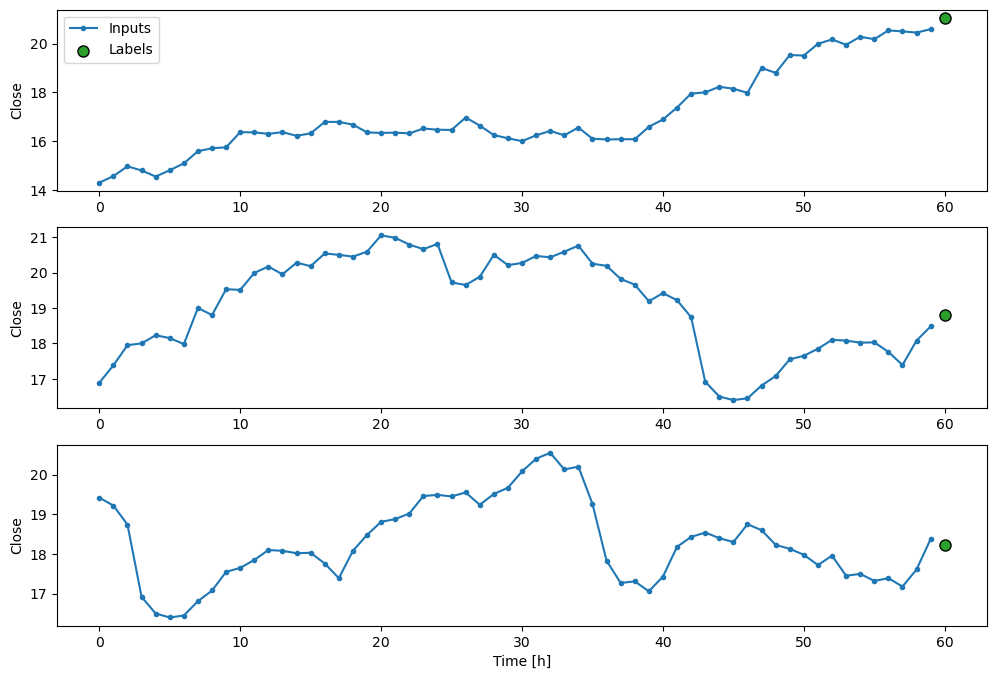

In [21]:
w1 = WindowGenerator(input_width=input_size, label_width=1, shift=1, train_df=training_df, val_df=None, test_df=test_df, label_columns=['Close'])

example_window = tf.stack([np.array(training_df[:w1.total_window_size]),
                           np.array(training_df[40:40+w1.total_window_size]),
                           np.array(training_df[80:80+w1.total_window_size])])  # TODO: organize example

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

w1.plot()

# Baseline

Para comparação com modelos mais complicados.

A baseline desse caso será um modelo que retorna a temperatura atual como a previsão.

In [26]:
# Modelo

class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]


# Single Step Window: a janela para o caso é de entrada única
    
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    train_df=training_df, val_df=None, test_df=test_df,
    label_columns=['Close'])

# Auxiliar: column_indices

column_indices = {name: i for i, name in enumerate(dataframe.columns)}

In [29]:
baseline = Baseline(label_index=column_indices['Close'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
# val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test)

{'Baseline': [0.1343148797750473, 0.27175670862197876]}

# Rede Neural

Foi implementada uma RNN, adequada para predição de séries temporais.

In [22]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(input_size, 1)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.LSTM(units=50))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

A próxima célula captura o output (longo) para a variável history

In [23]:
# %%capture history
# model.fit(window.train, epochs=100)

# Avaliando modelo

In [24]:
# performance['LSTM'] = model.evaluate(window.test)

TODOs:
- Considerar que existem dias faltantes na entrada
- Revisar divisão de dados entre treino, avaliação e teste
- Melhorar modelo
- Revisar epochs e batch size